In [43]:
import openai
import os
from dotenv import load_dotenv
from tqdm import tqdm
from openai import OpenAI
from diffusers import StableDiffusionPipeline
from diffusers import DiffusionPipeline
import torch
import json
import accelerate
import clip
from torchmetrics.image.inception import InceptionScore
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.chains import SequentialChain, LLMChain
from langchain import PromptTemplate
from PIL import Image
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7, max_tokens=100)
llm.invoke("Describe large language models.")

AIMessage(content='Large language models are advanced artificial intelligence systems that are capable of understanding and generating human language at a high level. These models are trained on massive amounts of text data from the internet, books, articles, and other sources to develop a deep understanding of language')

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to(device)

/Users/pandavis/miniconda3/lib/python3.11/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.52it/s]


StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.27.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
def generate_image(narrative):
    with torch.no_grad():
        image = pipe(narrative).images[0]
    return image

### Zero Shot

In [35]:
def get_prompt_template():
        return """
        The image, limited to a 50-token description, vividly brings the caption to life by detailing the setting, characters, and key elements. 
        It captures the mood through time of day, weather, and emotions, with a focus on colors, textures, and significant objects for depth. 
        Aim for a rich, immersive visual narrative, concisely under 50 tokens.
    
        Caption: {caption}
        
        """

In [36]:
class ZeroShotUtility:
    def __init__(self, template):
        self.template = template

    def __str__(self):
        return f"{self.template}"

    def generative_narrative(self, caption):
        prompt_template = ChatPromptTemplate.from_template(self.template)
        message = prompt_template.format_messages(caption=caption)
        response = llm(message)
        return response.content

In [40]:
prompt_template = get_prompt_template()
zeroShot = ZeroShotUtility(template=prompt_template)
caption = "A dog and a cat fighting"
zeroShot.generative_narrative(caption=caption)

'Two pets clash in a sunlit garden, fur bristling, amidst scattered toys and a overturned water bowl. Emotions flare in this colorful, chaotic scene.'

### Few Shots

In [28]:
class FewShot:

    @staticmethod
    def get_examples():
        examples = [
            {
                "caption": "The old man and the boat.",
                "narrative": """
                The image depicts an old man in a small boat, surrounded by a peaceful lake. He is wearing a tattered hat and a weathered coat, 
                and his hands are resting on the oars. The sun is setting in the background casting a warm orange glow over the scene. 
                The boat is weathered and worn but still sturdy and the old man looks content and at ease.
                """
            },
            {
                "caption": "A city intersection without cars.",
                "narrative": """
                The city intersection is eerily quiet, with no cars in sight. The absence of traffic creates a surreal atmosphere, 
                illuminated by dramatic lighting that casts long shadows across the empty street.
                """
            }
        ]
        return examples

    @staticmethod
    def get_example_template():
        template = """
        Caption: {caption}
         {narrative}
        """
        example_variables = ["caption", "narrative"]
        return template, example_variables

    @staticmethod
    def get_prefix():
        return f"""
        The image, limited to a 50-token description, vividly brings the caption to life by detailing the setting, characters, and key elements. 
        It captures the mood through time of day, weather, and emotions, with a focus on colors, textures, and significant objects for depth. 
        Aim for a rich, immersive visual narrative, concisely under 50 tokens.
        """

    @staticmethod
    def get_suffix():
        return """
                Caption: {caption}
                """

In [29]:
class FewShotUtility:
    def __init__(self, examples, prefix, suffix, input_variables, example_template, example_variables):
        self.examples = examples
        self.prefix = prefix
        self.suffix = suffix
        self.input_variables = input_variables
        self.example_template = example_template
        self.example_variables = example_variables

    def get_prompt(self, question):
        prompt_template = FewShotPromptTemplate(
            examples=self.examples,
            example_prompt=self.get_prompt_template(),
            prefix=self.prefix,
            suffix=self.suffix,
            input_variables=self.input_variables
        )
        prompt = prompt_template.format(caption=caption)
        return prompt

    def get_prompt_template(self):
        example_prompt = PromptTemplate(
            input_variables=self.example_variables,
            template=self.example_template
        )
        return example_prompt

    @staticmethod
    def generative_narrative(prompt):
        prompt_template = ChatPromptTemplate.from_template(prompt)
        message = prompt_template.format_messages()
        response = llm(message)
        return response.content

In [32]:
examples = FewShot.get_examples()
prefix = FewShot.get_prefix()
suffix = FewShot.get_suffix()
example_template, example_variables = FewShot.get_example_template()

fewShot = FewShotUtility(examples=examples,
                            prefix=prefix,
                            suffix=suffix,
                            input_variables=["caption"],
                            example_template=example_template,
                            example_variables=example_variables
                            )
caption = "A cat and a dog fighting."
prompt = fewShot.get_prompt(caption)
fewShot.generative_narrative(prompt)

'The image shows a cat and a dog locked in a fierce battle. Fur is flying, claws and teeth are bared, and the intensity of their rivalry is palpable. The background is blurred, focusing solely on the intense confrontation between the two animals'

### Chain of Thoughts

In [14]:
class SeqChainPrompt:
    @staticmethod
    def get_first_template():
        return """
        Based on the brief caption provided, expand it into a detailed description suitable for image generation. 
        The image, limited to a 50-token description, vividly brings the caption to life by detailing the setting, characters, and key elements. 
        It captures the mood through time of day, weather, and emotions, with a focus on colors, textures, and significant objects for depth. 
        Aim for a rich, immersive visual narrative, concisely under 50 tokens.

        Caption: {caption}
        """

    @staticmethod
    def get_second_template(input_key):
        key = "{" + input_key + "}"
        return f"""
        Given the detailed description below, enrich it further by adding specific visual details such as colors, textures, and lighting. 
        These details will help in creating an image that closely matches the envisioned scene. Consider the emotional tone and thematic elements in your enhancements.

        Detailed Narrative: {key}
        """
    
    @staticmethod
    def get_third_template(input_key):
        key = "{" + input_key + "}"
        return f"""
        Review the enriched description below. Make any final adjustments to ensure it's fully prepared for image generation. 
        The description should vividly convey the intended scene, complete with all necessary details for creating a compelling image.

        Enriched Narrative: {key}
        """

In [15]:
class ChainUtility:
    def __init__(self, input_variables):
        self.input_variables = input_variables

    def get_chain(self, template, output_key):
        prompt = ChatPromptTemplate.from_template(template)
        chain = LLMChain(llm=llm, prompt=prompt,
                         output_key=output_key
                         )
        return chain

    def get_overall_chain(self, chains, output_variables):
        overall_chain = SequentialChain(
            chains=chains,
            input_variables=self.input_variables,
            output_variables=output_variables,
            verbose=True
        )
        return overall_chain

    @staticmethod
    def print_completion(chain, start):
        resp = chain(start)
        return resp['enriched_narrative']

In [18]:
chains = []
output_variables = []
input_variables = ["caption"]

chainUtility = ChainUtility(input_variables=input_variables)

first_template = SeqChainPrompt.get_first_template()
first_output_key = "detailed_narrative"
output_variables.append(first_output_key)
first_chain = chainUtility.get_chain(template=first_template, output_key=first_output_key)
chains.append(first_chain)

second_template = SeqChainPrompt.get_second_template(first_output_key)
second_output_key = "enriched_narrative"
output_variables.append(second_output_key)
second_chain = chainUtility.get_chain(template=second_template, output_key=second_output_key)
chains.append(second_chain)



overall_chain = chainUtility.get_overall_chain(chains=chains,output_variables=output_variables)

caption = "A cat and a dog fighting"
chainUtility.print_completion(overall_chain,start=caption)



> Entering new SequentialChain chain...

> Finished chain.


"The sun, casting a warm golden hue on the scene, illuminates the fluffy white fur of the cat, making it appear almost ethereal against the rich green grass. The cat's fur shimmers in the sunlight, showcasing its soft texture and delicate"

In [22]:
def get_clip_score(image, text, model=clip_model, preprocess=preprocess):
    device = "cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu"
    model, preprocess = clip.load('ViT-B/32', device=device)
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text]).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)
    
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    clip_score = torch.matmul(image_features, text_features.T).item()
    
    return clip_score

clip_model, preprocess = clip.load('ViT-B/32', device=device)

In [23]:
extracted_data = []
combined_test_data = json.load(open('combined_test_data.json', 'r'))
for entry in combined_test_data:
    try:
        original_text = entry['caption']['original_text']
        image_url = entry['image_details']['url_o']
        extracted_data.append((original_text, image_url))
    except Exception as e:
        pass

In [ ]:
generated_images = []

for index, (caption, _) in enumerate(extracted_data[0:2]):
    caption_data = {"caption": caption}
    
    cot_chainUtility = chainUtility.print_completion(overall_chain, start=caption)
    cot_image = generate_image(cot_chainUtility)
    caption_data["cot_narrative"] = cot_chainUtility
    caption_data["cot_clip_score"] = get_clip_score(cot_image, caption)
    caption_data["cot_image"] = cot_image
    
    fewShot_narrative = fewShot.generative_narrative(caption)
    fewShot_image = generate_image(fewShot_narrative)
    caption_data["few_shot_narrative"] = fewShot_narrative
    caption_data["few_shot_clip_score"] = get_clip_score(fewShot_image, caption)
    caption_data["few_shot_image"] = fewShot_image
    
    
    zeroShot_narrative = zeroShot.generative_narrative(caption=caption)
    zeroShot_image = generate_image(zeroShot_narrative)
    caption_data["zero_shot_narrative"] = zeroShot_narrative
    caption_data["zero_shot_clip_score"] = get_clip_score(zeroShot_image, caption)
    caption_data["zero_shot_image"] = zeroShot_image

    
    generated_images.append(caption_data)

Original Caption: Lots of folks come out and set up tables to sell their crafts.

Chain of Thoughts Narrative:
coffee from a nearby cafe.

Enriched Narrative:
The bustling outdoor market on a sunny day is a riot of colors and textures. The stalls, painted in vibrant hues of red, yellow, and blue, are adorned with bunting in various shades 

Few-Shot Narrative:
They display handmade jewelry, paintings, pottery, knitted goods, and more. Some vendors even offer demonstrations of their crafting techniques, giving onlookers a glimpse into their creative process. The atmosphere is lively with music playing, food vendors selling snacks, 

Zero-Shot Narrative:
The bustling market square is filled with colorful tents and handmade goods, as vendors chat and showcase their crafts under the bright sun. 



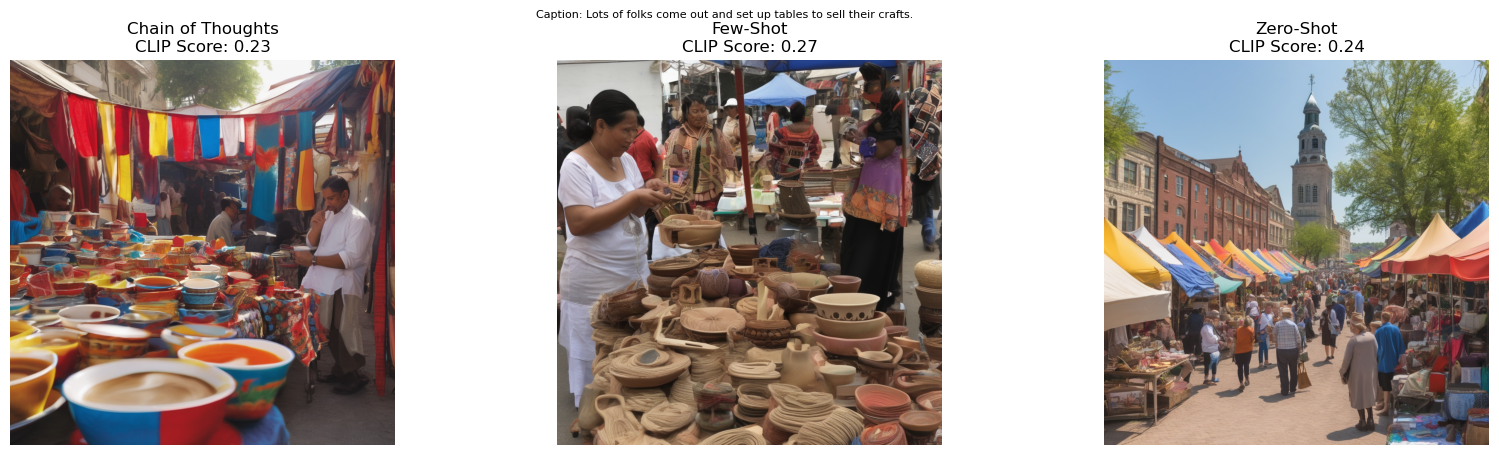

In [56]:
def plot_image(images_data, index):
    data = images_data[index]
    print(f"Original Caption: {data['caption']}\n")

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Caption: {data['caption']}", fontsize=8)

    axs[0].imshow(data["cot_image"])
    axs[0].axis('off')
    axs[0].set_title(f"Chain of Thoughts\nCLIP Score: {data['cot_clip_score']:.2f}")
    print("Chain of Thoughts Narrative:")
    print(data["cot_narrative"], "\n")

    axs[1].imshow(data["few_shot_image"])
    axs[1].axis('off')
    axs[1].set_title(f"Few-Shot\nCLIP Score: {data['few_shot_clip_score']:.2f}")
    print("Few-Shot Narrative:")
    print(data["few_shot_narrative"], "\n")

    axs[2].imshow(data["zero_shot_image"])
    axs[2].axis('off')
    axs[2].set_title(f"Zero-Shot\nCLIP Score: {data['zero_shot_clip_score']:.2f}")
    print("Zero-Shot Narrative:")
    print(data["zero_shot_narrative"], "\n")

    plt.show()


plot_image(generated_images, 1)